#Importacion librerias y datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, matthews_corrcoef

In [2]:
data = 'https://gist.githubusercontent.com/ahcamachod/1595316a6b37bf39baac355b081d9c3b/raw/98bc94de744764cef0e67922ddfac2a226ad6a6f/car_prices.csv'

ds = pd.read_csv(data)

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   mileage_per_year  10000 non-null  int64  
 2   model_year        10000 non-null  int64  
 3   price             10000 non-null  float64
 4   sold              10000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 390.8+ KB


In [4]:
ds.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


#Tratamiento datos

##Renombramiento columnas

In [5]:
dic_col = {
    'mileage_per_year': 'millas_anuales',
    'model_year': 'modelo',
    'price': 'precio',
    'sold': 'vendido'
}

In [6]:
ds = ds.rename(columns = dic_col)
ds.sample(5)

,Unnamed: 0,millas_anuales,modelo,precio,vendido
7170,7170,17890,2006,60985.25,no
9398,9398,17090,2013,45926.77,yes
9262,9262,22902,2004,92917.67,no
72,72,10358,2000,33596.02,yes
3055,3055,16568,2000,62280.40,no


##Modificacion en tipo de dato 'vendido'

In [7]:
cambio = {
    'no':0,
    'yes':1
}

In [8]:
ds.vendido = ds.vendido.map(cambio)
ds.sample(5)

,Unnamed: 0,millas_anuales,modelo,precio,vendido
5204,5204,4215,2000,77314.78,0
950,950,14971,2000,33657.30,1
571,571,7740,2002,79332.74,0
4595,4595,12052,1999,76421.50,0
839,839,19809,2002,42491.27,1


##Modificacion datos 'modelo' y nueva columna 'edad_del_modelo'

In [9]:
year_actual = datetime.today().year
ds['edad_del_modelo'] = year_actual - ds.modelo

ds.sample(5)

,Unnamed: 0,millas_anuales,modelo,precio,vendido,edad_del_modelo
518,518,23038,2006,60396.79,0,17
6488,6488,11351,1999,103253.06,0,24
2549,2549,7796,2005,46414.46,1,18
3823,3823,13057,1998,54151.07,1,25
1921,1921,5146,1998,22582.04,1,25


##Cambio de millas a kilometros

In [10]:
ds['km_anuales'] = ds.millas_anuales * 1.60934
ds.sample(5)

,Unnamed: 0,millas_anuales,modelo,precio,vendido,edad_del_modelo,km_anuales
3214,3214,11997,2007,86187.68,0,16,19307.25198
9209,9209,8577,2013,92355.13,1,10,13803.30918
7470,7470,14364,1998,16179.16,1,25,23116.55976
2617,2617,16776,2008,91409.30,0,15,26998.28784
638,638,16974,2000,60867.55,0,23,27316.93716


##Eliminacion columnas que no seran utilizadas en el analisis

In [11]:
ds = ds.drop(columns = ['Unnamed: 0', 'millas_anuales', 'modelo'], axis = 1)
ds.sample(5)

,precio,vendido,edad_del_modelo,km_anuales
5765,34687.79,1,24,29767.96198
5884,73687.07,0,22,28617.28388
7225,86871.61,0,12,23821.45068
9074,51513.60,1,16,23285.54046
921,89718.57,1,20,24051.58630


In [12]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   precio           10000 non-null  float64
 1   vendido          10000 non-null  int64  
 2   edad_del_modelo  10000 non-null  int64  
 3   km_anuales       10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 312.6 KB


#Visualizacion y analisis datos

Vista visual de los datos estadisticos, se puede observar las relaciones entre las distintas variables, y el histograma de cada variable

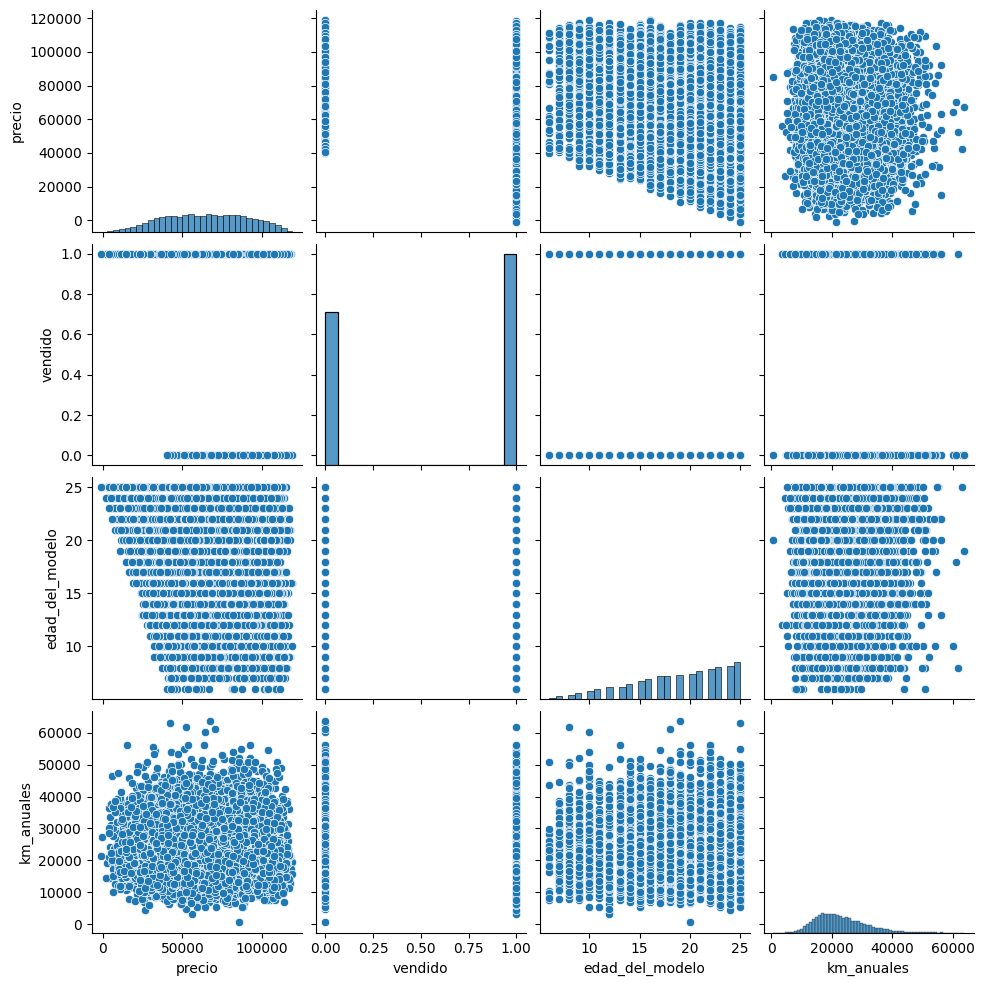

In [13]:
sns.pairplot(data = ds);

Analisis de outliers

In [14]:
columnas_numericas = ds.select_dtypes(include=['number']).columns.tolist()

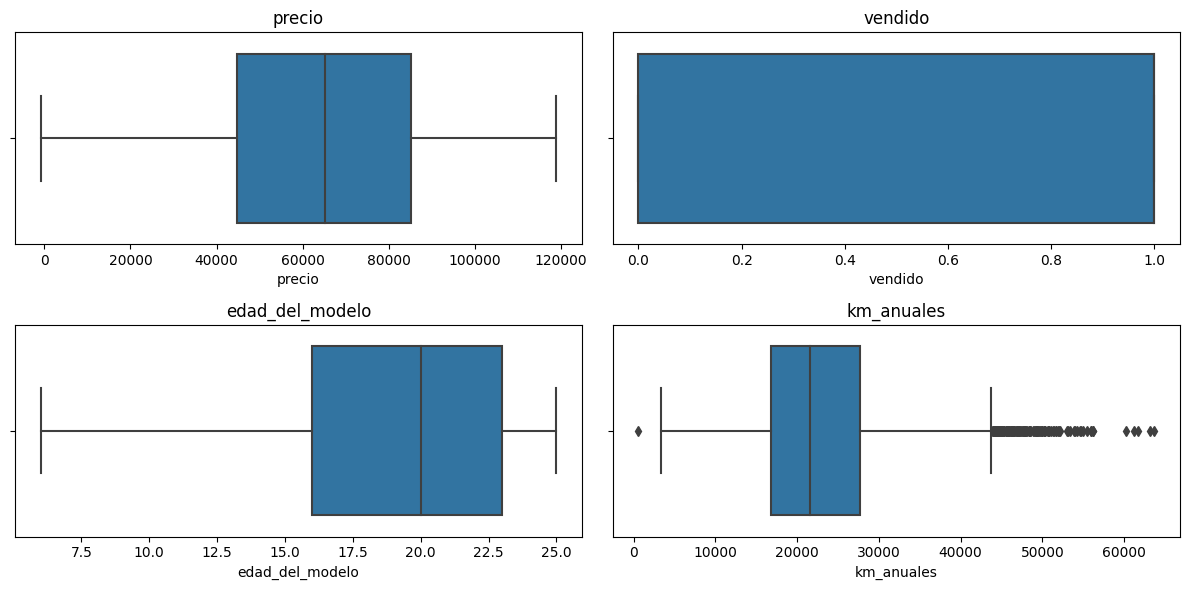

In [15]:
num_filas = 2
num_columnas = 2

fig, ax = plt.subplots(nrows=num_filas, ncols=num_columnas, figsize=(12, 3 * num_filas))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=col, data=ds, ax=ax[i // num_columnas, i % num_columnas])
    ax[i // num_columnas, i % num_columnas].set_title(col)

plt.tight_layout()
plt.show()

#EDA variables numericas

In [16]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [17]:
estadisticos_cont(ds.select_dtypes('number'))

,count,mean,median,std,min,25%,50%,75%,max
precio,10000.0,64842.373698,65225.68500,25250.592393,-840.36000,44796.375000,65225.68500,85111.237500,118929.72000
vendido,10000.0,0.580000,1.00000,0.493583,0.00000,0.000000,1.00000,1.000000,1.00000
edad_del_modelo,10000.0,18.855800,20.00000,4.687580,6.00000,16.000000,20.00000,23.000000,25.00000
km_anuales,10000.0,22825.898794,21594.92879,8060.494332,584.19042,16857.434165,21594.92879,27643.230845,63684.80248


Se puede observar que en 'precios' el valor minimo es un numero negativo, lo cual carece de sentido. Por lo tanto se deberian eliminar aquellos registros ue contengan valores menores a cero en su precio.





In [18]:
filtro_precio = (ds['precio']>0)
ds = ds[filtro_precio]
ds.sample(5)

,precio,vendido,edad_del_modelo,km_anuales
9610,94873.61,0,19,27516.49532
3595,18711.16,1,19,24959.25406
3210,24897.54,1,18,16469.98556
2966,86185.08,0,25,13174.05724
2811,71261.65,0,20,27308.89046


#Busqueda de Insights

## Tasa de ventas

In [19]:
ds.vendido.value_counts(normalize = True) * 100

1    57.991598
0    42.008402
Name: vendido, dtype: float64

Se venden el 58% de los automoviles

Analisis por demas variables

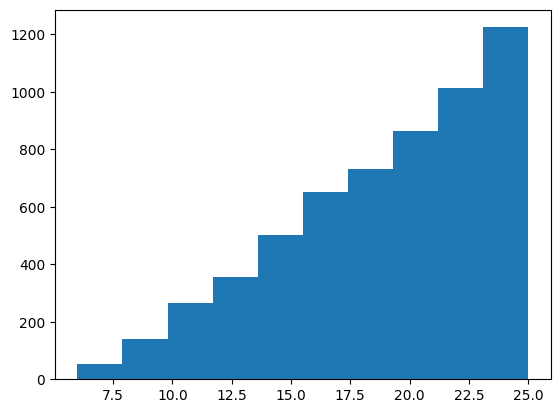

In [20]:
temp = ds.edad_del_modelo[ds['vendido'] == 1]
fig, ax = plt.subplots()
ax.hist(temp)
plt.show()

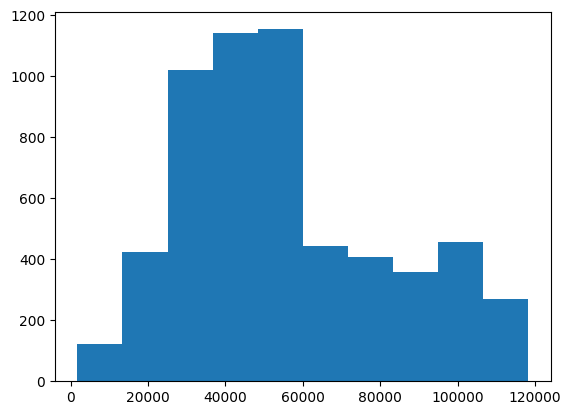

In [21]:
temp = ds.precio[ds['vendido'] == 1]
fig, ax = plt.subplots()
ax.hist(temp)
plt.show()

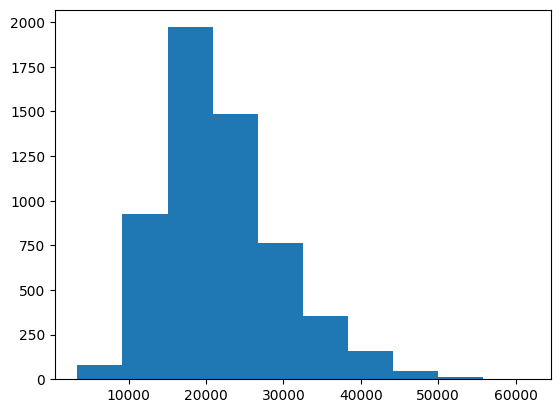

In [22]:
temp = ds.km_anuales[ds['vendido'] == 1]
fig, ax = plt.subplots()
ax.hist(temp)
plt.show()

Por lo tanto, se puede decir que el perfil tipico de un auto vendido es:

1.   Edad cercana a los 25 años
2.   Precio promedio de 40000 um
3.   km_anuales cercanos a los 20000



#Mapa de correlaciones

Para poder observar dependencias entre diferentes columnas

<Axes: >

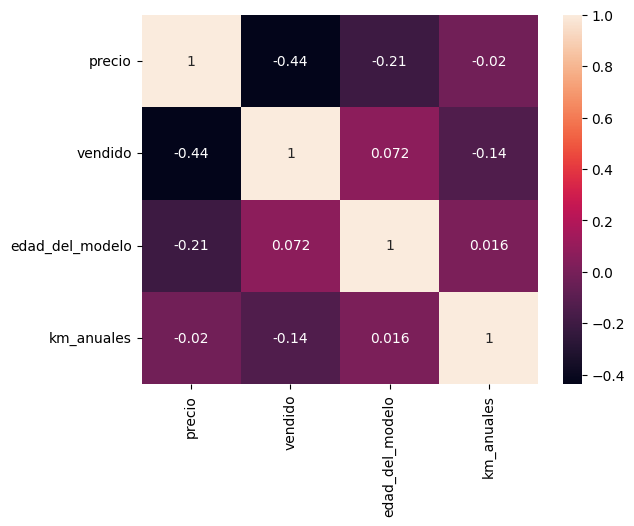

In [23]:
sns.heatmap(data=ds.corr(), annot=True)

#Aplicacion de Arbol de decision

Funciones para muestras resultados

In [24]:
def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)

In [25]:
labels = ['No_vendido', 'Vendido']

In [26]:
# DataFrame para una evaluación general al final
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','Time to Train','Time to Predict','Total Time'])

def muestra_metricas(model_name, y_test, y_predic, start_time=None, end_train_time=None, end_predict_time=None):
    """
    Función simple para personalizar las métrica a imprimir para cada modelo analizado.
    model_name: string con el nombre del modelo
    y_test: recibe el vector de salida real
    y_predic: recibe el vector de salida predicho por el modelo
    """

    accuracy = accuracy_score(y_test, y_predic)
    recall = recall_score(y_test, y_predic, average='weighted') # average permite definir cómo se computan estas métricas para múltiples clases de salida
    precision = precision_score(y_test, y_predic, average='weighted')
    f1s = f1_score(y_test, y_predic, average='weighted')
    MCC = matthews_corrcoef(y_test, y_predic)

    print("#######################################")
    print("Accuracy: "+ "{:.2%}".format(accuracy))
    print("Recall: "+ "{:.2%}".format(recall))
    print("Precision: "+ "{:.2%}".format(precision))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("MCC: "+ "{:.2%}".format(MCC))    # Matthews correlation coefficient: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

    if (start_time != None and end_train_time != None and end_predict_time != None):
        print("Tiempo de entrenamiento: {:.4f} s".format(end_train_time-start_time))
        print("Tiempo de predicción: {:.4f} s".format(end_predict_time-end_train_time))
        print("Tiempo total: {:.4f} s".format(end_predict_time-start_time))

    print("#######################################")
    model_performance.loc[model_name] = [accuracy, recall, precision, f1s, MCC, end_train_time-start_time, end_predict_time-end_train_time, end_predict_time-start_time]

##Modelo con datos sin escalar

Preparacion de datos para entrenamiento y prueba

In [27]:
X = ds[['edad_del_modelo','km_anuales','precio']]
y = ds.vendido

In [28]:
SEED = 42
np.random.seed(SEED) #Para establecer estado de aleatoreidad

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)
print(f'Se entrenó al modelo con {len(X_train)} elementos y se utilizan de prueba {len(X_test)} elementos')

Se entrenó al modelo con 7498 elementos y se utilizan de prueba 2500 elementos


Aplicacion del DecisionTreeClassifier con datos sin escalar y profundidad maxima = 3

In [29]:
# Marca de tiempo para tomar métricas
start = time.time()

#Entrenamiento
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X_train,y_train)
end_train = time.time()

#Predicciones
predicciones = model.predict(X_test)
end_predict = time.time()

tasa_acierto = accuracy_score(y_test, predicciones)

#Muestra resultados
print("Classification Report: \n", classification_report(y_test, predicciones))
muestra_metricas("DecisionTreeClassifier", y_test, predicciones, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      1050
           1       0.85      0.77      0.81      1450

    accuracy                           0.79      2500
   macro avg       0.78      0.79      0.79      2500
weighted avg       0.80      0.79      0.79      2500

#######################################
Accuracy: 78.76%
Recall: 78.76%
Precision: 79.51%
F1-Score: 78.89%
MCC: 57.57%
Tiempo de entrenamiento: 0.0381 s
Tiempo de predicción: 0.0024 s
Tiempo total: 0.0405 s
#######################################


###Matriz de confusion

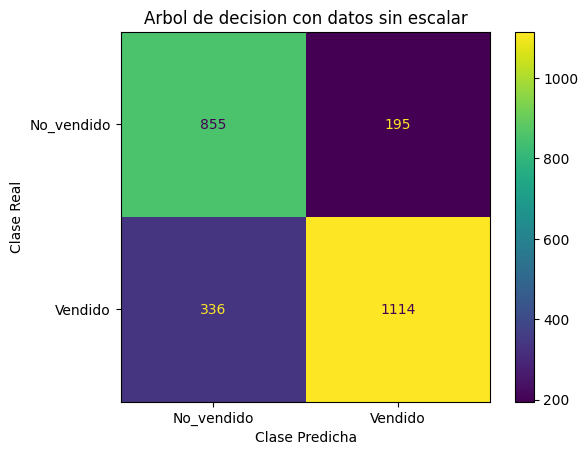

In [30]:
plot_confusion_matrix(y_test, predicciones, labels=labels, model_name='Arbol de decision con datos sin escalar')

###Vista de arbol en forma de grafo

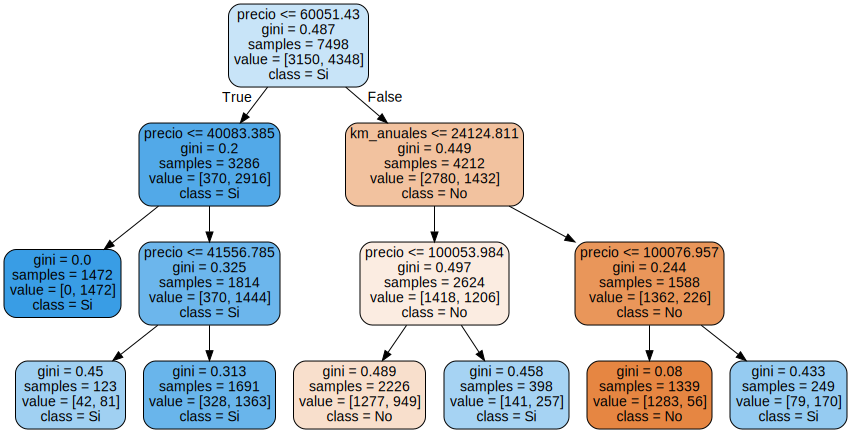

In [31]:
features = X.columns
dot_data = export_graphviz(model, feature_names = features, filled = True, rounded = True, class_names = ['No','Si'])
grafico = graphviz.Source(dot_data)
grafico

Class = Si significa que se vende y Class = No significa que no se vende, y a mayor saturacion del color, mayor probabilidad de que lo resultado en Class suceda.

##Modelo con datos escalados

Consiste en eliminar el valor medio de los datos y llevarlos a escala de forma que su desviación estándar sea 1

Preparacion de datos para entrenamiento y prueba

In [32]:
X = ds[['edad_del_modelo','km_anuales','precio']]
y = ds.vendido

In [33]:
SEED = 42
np.random.seed(SEED) #Para establecer estado de aleatoreidad

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)
print(f'Se entrenó al modelo con {len(X_train)} elementos y se utilizan de prueba {len(X_test)} elementos')

Se entrenó al modelo con 7498 elementos y se utilizan de prueba 2500 elementos


Aplicacion del DecisionTreeClassifier con datos escalados y profundidad maxima = 3

In [34]:
# Marca de tiempo para tomar métricas
start = time.time()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Entrenamiento
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X_train,y_train)
end_train = time.time()

#Predicciones
predicciones = model.predict(X_test)
end_predict = time.time()

#Muestra resultados
print("Classification Report: \n", classification_report(y_test, predicciones))
muestra_metricas("DecisionTreeClassifier", y_test, predicciones, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      1050
           1       0.85      0.77      0.81      1450

    accuracy                           0.79      2500
   macro avg       0.78      0.79      0.79      2500
weighted avg       0.80      0.79      0.79      2500

#######################################
Accuracy: 78.76%
Recall: 78.76%
Precision: 79.51%
F1-Score: 78.89%
MCC: 57.57%
Tiempo de entrenamiento: 0.0451 s
Tiempo de predicción: 0.0007 s
Tiempo total: 0.0458 s
#######################################


###Matriz de confusion

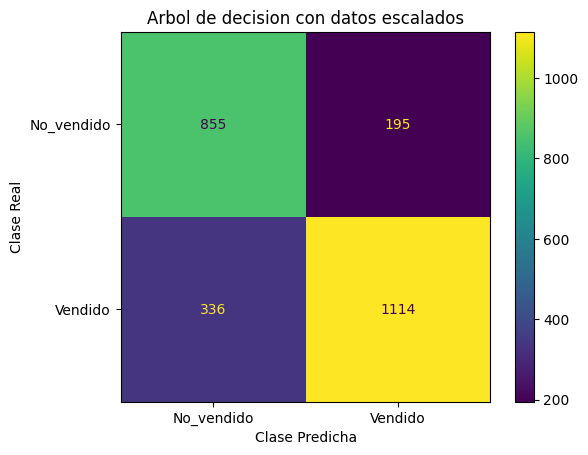

In [35]:
plot_confusion_matrix(y_test, predicciones, labels=labels, model_name='Arbol de decision con datos escalados')

###Vista del arbol en forma de grafo

In [36]:
features = X.columns
dot_data = export_graphviz(model, feature_names = features, filled = True, rounded = True, class_names = ['No','Si'])
grafico = graphviz.Source(dot_data)

Arbol de decision con datos escalados

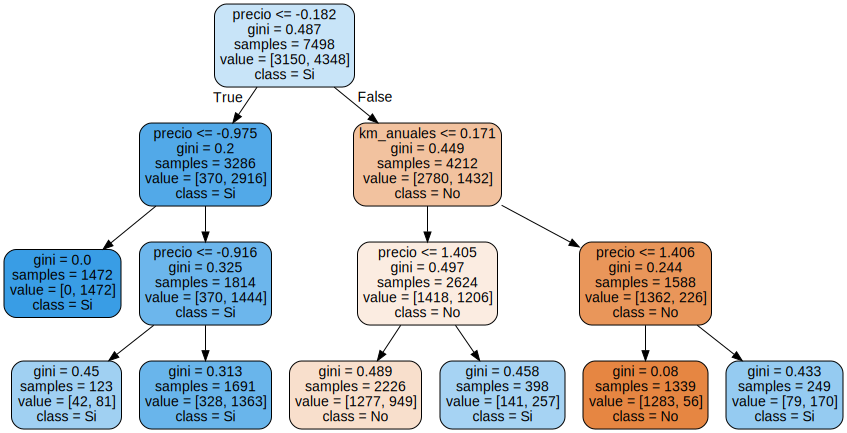

In [37]:
grafico

Se puede observar que no hubo diferencias en los resultados entre escalar o no escalar los datos de entrada, ya que se obtuvo metricas similares, matrices de confusion similares y, por lo tanto, arboles de decision similares

#Analisis tratando outliers de kilometros_anuales

<Axes: >

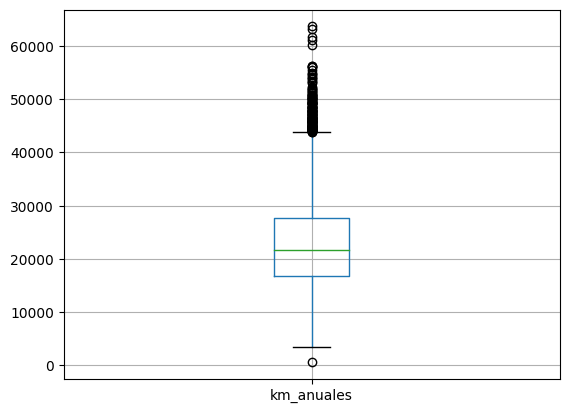

In [38]:
ds.boxplot(['km_anuales'])

In [39]:
data_km_anuales = ds['km_anuales']

In [40]:
Q1 = data_km_anuales.quantile(0.25)
Q3 = data_km_anuales.quantile(0.75)
IIQ = Q3 - Q1 #Intervalo intercuartil
lim_inf = Q1 - 1.5*IIQ
lim_sup = Q3 + 1.5*IIQ

In [41]:
seleccion = (data_km_anuales >= lim_inf) & (data_km_anuales <= lim_sup)

In [42]:
prueba = ds[seleccion]

In [43]:
prueba.shape

(9852, 4)

<Axes: >

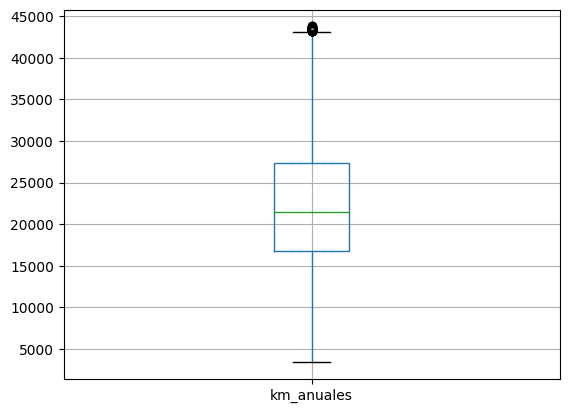

In [44]:
prueba.boxplot(['km_anuales'])

In [45]:
ds = prueba

##Modelo con datos sin escalar y outliers excluidos

In [46]:
X = ds[['edad_del_modelo','km_anuales','precio']]
y = ds.vendido

In [47]:
SEED = 42
np.random.seed(SEED) #Para establecer estado de aleatoreidad

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)
print(f'Se entrenó al modelo con {len(X_train)} elementos y se utilizan de prueba {len(X_test)} elementos')

Se entrenó al modelo con 7389 elementos y se utilizan de prueba 2463 elementos


In [48]:
# Marca de tiempo para tomar métricas
start = time.time()

#Entrenamiento
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X_train,y_train)
end_train = time.time()

#Predicciones
predicciones = model.predict(X_test)
end_predict = time.time()

tasa_acierto = accuracy_score(y_test, predicciones)

#Muestra resultados
print("Classification Report: \n", classification_report(y_test, predicciones))
muestra_metricas("DecisionTreeClassifier", y_test, predicciones, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      1031
           1       0.85      0.77      0.81      1432

    accuracy                           0.79      2463
   macro avg       0.78      0.79      0.78      2463
weighted avg       0.79      0.79      0.79      2463

#######################################
Accuracy: 78.77%
Recall: 78.77%
Precision: 79.40%
F1-Score: 78.89%
MCC: 57.38%
Tiempo de entrenamiento: 0.0520 s
Tiempo de predicción: 0.0027 s
Tiempo total: 0.0547 s
#######################################


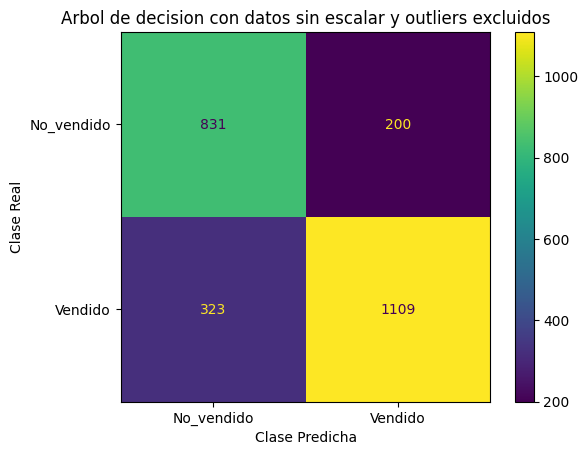

In [49]:
plot_confusion_matrix(y_test, predicciones, labels=labels, model_name='Arbol de decision con datos sin escalar y outliers excluidos')

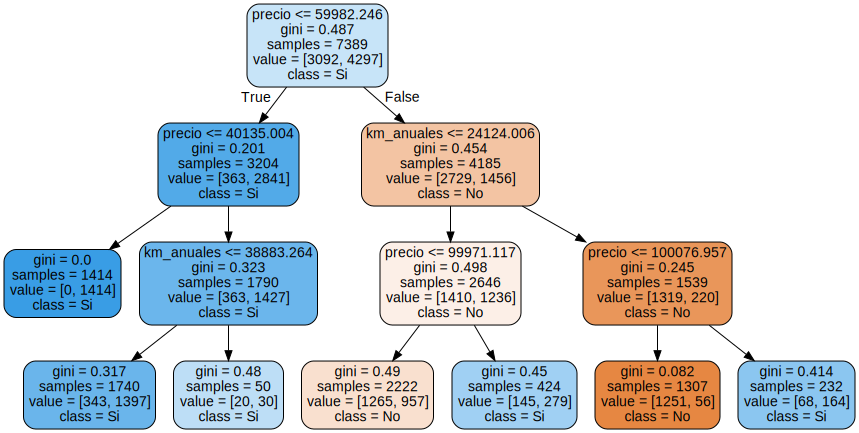

In [50]:
features = X.columns
dot_data = export_graphviz(model, feature_names = features, filled = True, rounded = True, class_names = ['No','Si'])
grafico = graphviz.Source(dot_data)
grafico

##Modelo con datos escalados y outliers excluidos

In [51]:
X = ds[['edad_del_modelo','km_anuales','precio']]
y = ds.vendido

In [52]:
SEED = 42
np.random.seed(SEED) #Para establecer estado de aleatoreidad

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)
print(f'Se entrenó al modelo con {len(X_train)} elementos y se utilizan de prueba {len(X_test)} elementos')

Se entrenó al modelo con 7389 elementos y se utilizan de prueba 2463 elementos


In [53]:
# Marca de tiempo para tomar métricas
start = time.time()

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Entrenamiento
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X_train,y_train)
end_train = time.time()

#Predicciones
predicciones = model.predict(X_test)
end_predict = time.time()

#Muestra resultados
print("Classification Report: \n", classification_report(y_test, predicciones))
muestra_metricas("DecisionTreeClassifier", y_test, predicciones, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      1031
           1       0.85      0.77      0.81      1432

    accuracy                           0.79      2463
   macro avg       0.78      0.79      0.78      2463
weighted avg       0.79      0.79      0.79      2463

#######################################
Accuracy: 78.77%
Recall: 78.77%
Precision: 79.40%
F1-Score: 78.89%
MCC: 57.38%
Tiempo de entrenamiento: 0.0242 s
Tiempo de predicción: 0.0006 s
Tiempo total: 0.0248 s
#######################################


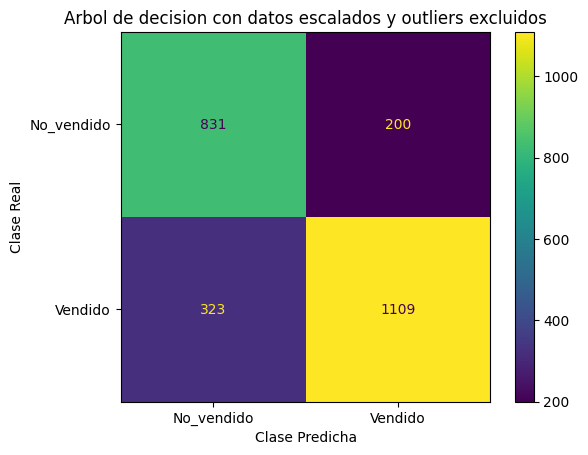

In [54]:
plot_confusion_matrix(y_test, predicciones, labels=labels, model_name='Arbol de decision con datos escalados y outliers excluidos')

In [55]:
features = X.columns
dot_data = export_graphviz(model, feature_names = features, filled = True, rounded = True, class_names = ['No','Si'])
grafico = graphviz.Source(dot_data)

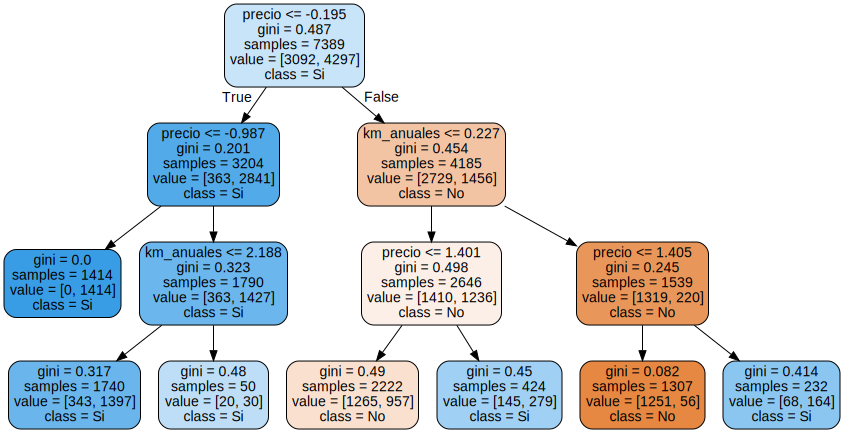

In [56]:
grafico

Se puede observar que, para ambos casos (datos escalados y sin escalar), se obtuvieron resultados similares incluyendo o excluyendo los outliers ubicados en los kilometros por año